In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/松尾研究所/世界モデルと知能/最終課題/共有フォルダ/実験")

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデル（別の構成）
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 12, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Conv2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Flatten(),

            nn.Linear(12*7*7, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, z_dim * 2),
            nn.BatchNorm1d(z_dim * 2),
            nn.ReLU(),
        )

        self.enc_mean = nn.Linear(z_dim * 2, z_dim)
        self.enc_std = nn.Linear(z_dim * 2, z_dim)

        # Decoder
        self.dec_lin = nn.Linear(z_dim, z_dim * 2)
        self.dec = nn.Sequential(
            nn.Linear(z_dim*2, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, 12*7*7),
            nn.BatchNorm1d(12*7*7),
            nn.ReLU(),

            nn.Unflatten(1, (12, 7, 7)),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.ConvTranspose2d(12, 8, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.ConvTranspose2d(8, 5, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(5, 3, kernel_size=1, stride=1, padding=0),

            nn.Sigmoid()
        )

    def encoder(self, x):
        h = self.enc(x)
        mean = self.enc_mean(h)
        std = F.softplus(self.enc_std(h))

        return mean, std

    def decoder(self, z):
        h = self.dec_lin(z)
        x = self.dec(h)
        return x

    def sample_z(self, mean: torch.Tensor, std: torch.Tensor):
        if self.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def loss(self, x: torch.Tensor):
        mean, std = self.encoder(x)

        z = self.sample_z(mean, std)
        y = self.decoder(z)

        x_flat = x.view(x.size(0), -1)
        y_flat = y.view(y.size(0), -1)
        KL_loss = nn.KLDivLoss(reduction='batchmean')(mean, std)
        reconstruction_loss = nn.MSELoss()(x_flat, y_flat)

        return -KL_loss, reconstruction_loss, y, z

In [ ]:
import json
with open('./data.json') as f:
    data = json.load(f)

model = VAE(z_dim=36).to(device)
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [ ]:
def show_imgs(imgs, labels=None):
    num_images = len(imgs)

    fig = plt.figure(figsize=(16, 6))
    for i in range(num_images):

        ax = fig.add_subplot(2, num_images, i+1)
        ax.imshow(imgs[i].permute(1, 2, 0))
        if labels is not None:
            ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
SIZE = 20
for label in data:
    print(f'>> {label}')
    z = random.choice(data[label]["normal"])
    for j in range(len(z)):
        print(f'第{j}成分の変化')
        n = random.randint(0, len(z) - 1)
        zs = np.array([z for _ in range(SIZE)])
        vs = np.linspace(-2, 2, len(zs))
        for k in range(len(zs)):
            zs[k][j] = vs[k]
        zs = torch.from_numpy(zs).float().to(device)

        x_reconstructed = model.decoder(zs)
        x_reconstructed = x_reconstructed.cpu().detach()
        show_imgs(x_reconstructed)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data.keys()

dict_keys(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracu

In [ ]:
# z1からz2方向に（z1 - z2）で向かう道のりを描画する
# z1: リンゴ, z2: バナナなら、リンゴ → バナナに変わる

z1 = random.choice(data["Apple Red 1"]["normal"])
z2 = random.choice(data["Banana"]["normal"])

way = z1 - z2

# 錯視を交えて可視化する

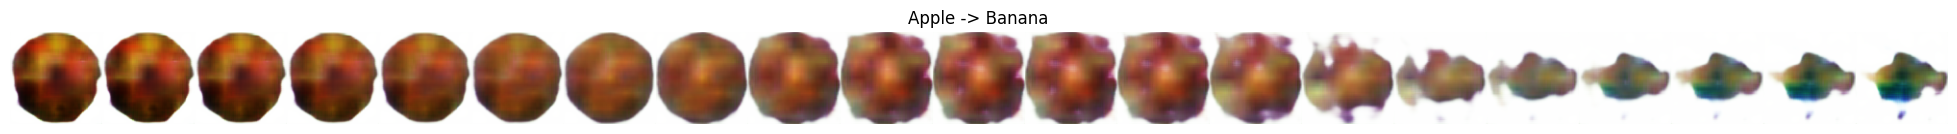

In [ ]:
# リンゴとバナナの潜在変数
z1 = np.array(random.choice(data["Apple Red 1"]["normal"]))
z2 = np.array(random.choice(data["Banana"]["normal"]))

# 変化の軌跡を生成
num_steps = 20
zs = [z1]
for alpha in np.linspace(0, 1, num_steps):
    zs.append(z1 + alpha * (z2 - z1))
zs = torch.tensor(zs)

images = model.decoder(zs.float().to(device))
images = images.cpu().detach().numpy()

images = images.transpose(0, 2, 3, 1)

grid_image = np.concatenate(images, axis=1)
plt.figure(figsize=(20, 6))
plt.imshow(grid_image)
plt.tight_layout()
plt.axis('off')
plt.title('Apple -> Banana')
plt.show()

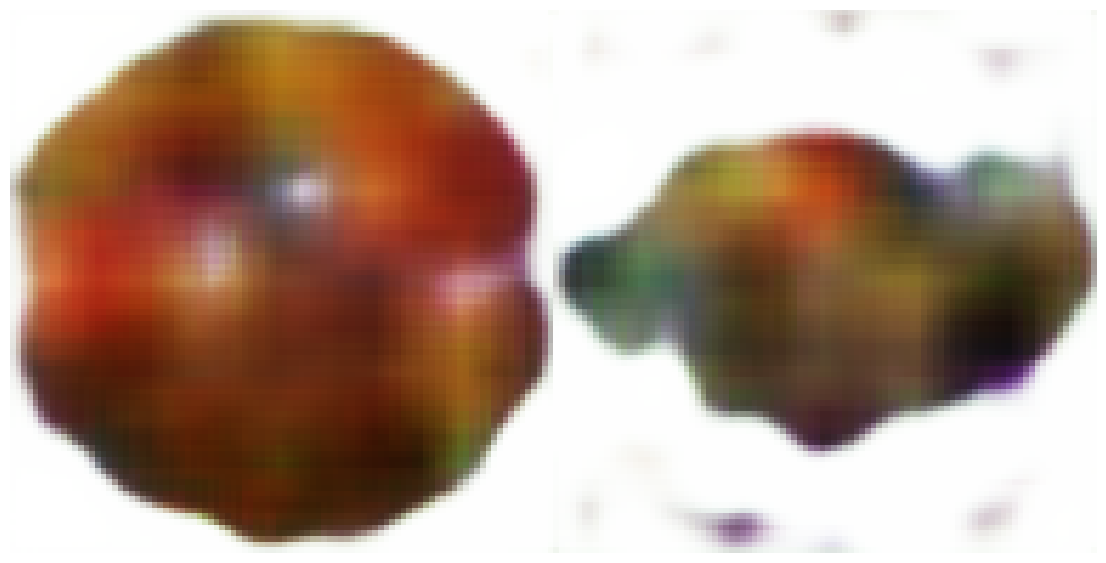

In [ ]:
# リンゴとバナナの潜在変数
z1 = np.array(random.choice(data["Apple Red 1"]["normal"]))
z2 = np.array(random.choice(data["Banana"]["normal"]))

zs = torch.tensor([z1, z2])

images = model.decoder(zs.float().to(device))
images = images.cpu().detach().numpy()

images = images.transpose(0, 2, 3, 1)

grid_image = np.concatenate(images, axis=1)
plt.figure(figsize=(20, 6))
plt.imshow(grid_image)
plt.tight_layout()
plt.axis('off')
plt.show()

In [ ]:
len(data.keys())

131

In [ ]:
fruits-360